In [ ]:
#Here we install R, the bridge package rpy2 between the two languages and the R package Salso. Need to install each time since the Colab runtime is temporary
!apt-get install -y r-base
!pip install rpy2
!curl --proto '=https' --tlsv1.2 -sSf https://sh.rustup.rs | sh -s -- --no-modify-path -y
!Rscript -e "install.packages('salso', repos='http://cran.r-project.org')"

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
r-base is already the newest version (4.5.2-1.2204.0).
0 upgraded, 0 newly installed, 0 to remove and 1 not upgraded.
info: downloading installer
info: profile set to 'default'
info: default host triple is x86_64-unknown-linux-gnu
info: syncing channel updates for 'stable-x86_64-unknown-linux-gnu'
info: latest update on 2025-12-11, rust version 1.92.0 (ded5c06cf 2025-12-08)
info: downloading component 'cargo'
info: downloading component 'clippy'
info: downloading component 'rust-docs'
info: downloading component 'rust-std'
info: downloading component 'rustc'
info: downloading component 'rustfmt'
info: installing component 'cargo'
 10.3 MiB /  10.3 MiB (100 %)   6.8 MiB/s in  1s
info: installing component 'clippy'
info: installing component 'rust-docs'
 20.5 MiB /  20.5 MiB (100 %)   3.2 MiB/s in  5s
info: installing component 'rust-std'
 28.0 MiB /  28.0 MiB (100 %)   8.8 MiB/s in  3s
info:

In [ ]:
import math
import os
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as ss
from scipy.stats import nct
from tqdm import tqdm
import time
import random
import copy
plt.style.use('default')
import pandas as pd
import rpy2.robjects as robjects
from rpy2.robjects.packages import importr
from rpy2.robjects import pandas2ri
salso = importr("salso") #import salso package in R
#To convert Python vector/matrices into R ones
from rpy2.robjects import r, IntVector
from rpy2.robjects.vectors import IntMatrix
import rpy2.robjects.packages as rpackages
from rpy2.robjects import numpy2ri

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
os.chdir(r'/content/drive/MyDrive/Colab Notebooks/Thesis/Plots/mean variance')

In [ ]:
np.random.seed(1)

# Simulation

### Generating the mixture

Here we first generate a mixture distribution on normals and then we sample from it. The goal is then to approximate using the sample the real distribution. The following are the parameters of the distributions.


Mixture of $T = 3$ normal distributions. We have: $\mathcal{N}(0, 2)$, $\mathcal{N}(-8, 2)$, $\mathcal{N}(18, 5)$ with weights $0.5, 0.25, 0.25$ respectively.

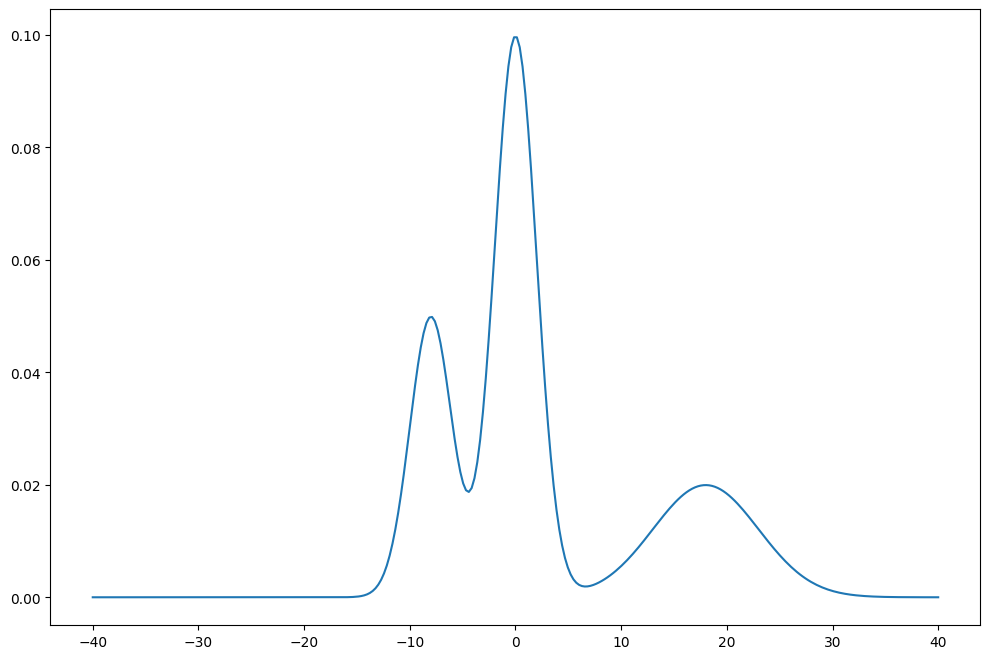

In [ ]:
#Generating true distribution
n = 300
support = np.linspace(-40, 40, n)
weights = np.array([0.5, 0.25, 0.25])
dens1 = ss.norm.pdf(support, 0, 2)
dens2 = ss.norm.pdf(support, -8, 2)
dens3 = ss.norm.pdf(support, 18, 5)
densities = np.array([dens1, dens2, dens3])
mixture = np.dot(weights, densities)
fix, ax = plt.subplots(figsize = (12, 8))
ax.plot(support, mixture)
#plt.savefig('real_dens.pdf')

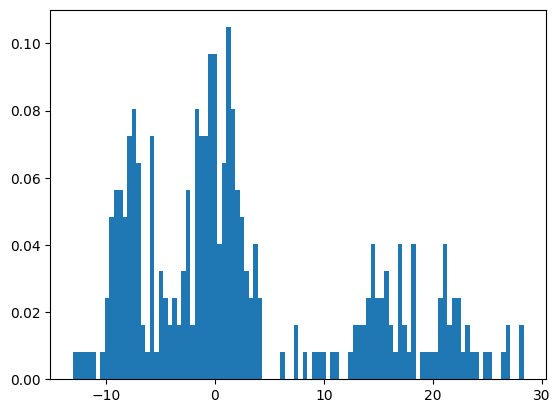

In [ ]:
#Generating a random sample from the above mixture
un_val = np.random.uniform(0, 1, n)
sample = np.empty(n)
counter = [0, 0, 0]
colors = []
for i in range(n):
    if un_val[i] < weights[0]:
        sample[i] = np.random.normal(0, 2)
        counter[0] += 1
        colors.append('blue')
    elif un_val[i] < (weights[0] + weights[1]):
        sample[i] = np.random.normal(-8, 2)
        counter[1] += 1
        colors.append('orange')
    else:
        sample[i] = np.random.normal(18, 5)
        counter[2] += 1
        colors.append('green')
plt.hist(sample, bins = 100, density = True);

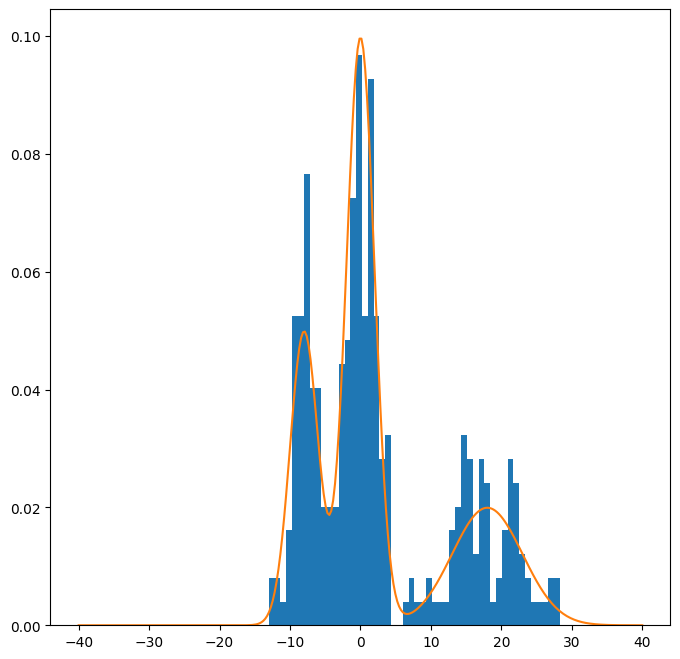

In [ ]:
#Combining plots
fig = plt.figure(figsize = (8,8))
ax1 = fig.add_subplot(111)
plt.hist(sample, bins = 50, density = True)
plt.plot(support, mixture)
plt.show()

### Functions

Below we group all the function used in the following cells: there are some used in the Gibbs sampler and others used for sampling/estimating the predictive distribution.

In [ ]:
def t_student_eval(x, df, mu, sigmaq):
  logfx = math.lgamma((df + 1)/2) - math.lgamma(df/2) - 1/2*np.log(math.pi*df*sigmaq) - ((df + 1)/2)*np.log(1 + ((x - mu)**2)/(df*sigmaq))
  return np.exp(logfx)

In [ ]:
def t_student_eval(x, df, mu, sigmaq):
    return ((math.gamma((df + 1)/2))/(math.gamma(df/2)*math.sqrt(math.pi*df*sigmaq)))*(1 + ((x - mu)**2)/(df*sigmaq))**(-(df + 1)/2)

In [ ]:
def cluster_prob(element_index, gamma):
    element = sample[element_index]
    k = len(partition)
    probs_unnorm = [0 for i in range(k)]
    for i in range(k):
        #Computing the probabilities (unnormalized) for each cluster
        n_i = len(partition[i])
        cluster_data_sum = sum(sample[partition[i]])
        a_n = a + (n_i)/2
        v = 2*a_n
        mu_n = (cluster_data_sum + beta*mu_0)/(n_i + beta)
        cl_mean = np.mean(sample[partition[i]])
        sum_squared_res = np.sum((sample[partition[i]] - cl_mean)**2)
        b_n = b + 1/2*(sum_squared_res + ((beta*n_i)*(cl_mean - mu_0)**2)/(beta + n_i))
        old_cl_var = (2*b_n*(1 + n_i + beta))/(v*(n_i + beta))
        if old_cl_var <= 0:
            print(old_cl_var, n_i, psi1, psi2, cluster_data_sum, lamb)
            raise ValueError('Negative variance!')
        probs_unnorm[i] = (1 + n_i)*(n + gamma - k - 1)*t_student_eval(element, v, mu_n, old_cl_var)

    #Computing the probability (unnormalized) for a new cluster
    v = 2*a
    new_cl_var = 2*b*(1 + beta)/(beta*v)
    if new_cl_var <= 0:
        print(new_cl_var)
        raise ValueError('Negative variance!')
    probs_unnorm.append((k**2 - gamma*k)*t_student_eval(element, v, mu_0, new_cl_var))

    #Normalizing
    Z = sum(probs_unnorm)
    probs_unnorm = np.array(probs_unnorm)
    probs_norm = probs_unnorm/Z
    return probs_norm

In [ ]:
def cluster_assign(probs):
    U = np.random.uniform(0, 1)
    cum = probs[0]
    i = 0
    while U > cum:
        i += 1
        cum += probs[i]
    return i

In [ ]:
def t_student_vector_eval(support, df, mu, sigmaq):
    probs = []
    for point in support:
        probs.append(t_student_eval(point, df, mu, sigmaq))
    return probs

In [ ]:
def posterior_predictive_pdf(support, gamma):
    S = len(partitions)
    pred_sample = []
    for s in range(S):
        k = len(partitions[s])
        part = partitions[s]
        probs_part = []
        weights_unnorm = []

        #Old clusters probabilities
        for i in range(k):
            n_i = len(part[i])
            cluster_data_sum = sum(sample[part[i]])
            a_n = a + (n_i)/2
            v = 2*a_n
            mu_n = (cluster_data_sum + beta*mu_0)/(n_i + beta)
            cl_mean = np.mean(sample[part[i]])
            sum_squared_res = np.sum((sample[part[i]] - cl_mean)**2)
            b_n = b + 1/2*(sum_squared_res + ((beta*n_i)*(cl_mean - mu_0)**2)/(beta + n_i))
            old_cl_var = (2*b_n*(1 + n_i + beta))/(v*(n_i + beta))
            probs_part.append(t_student_vector_eval(support, v, mu_n, old_cl_var))
            weights_unnorm.append((1 + n_i)*(n + gamma - k))

        #New cluster probability
        v = 2*a
        new_cl_var = 2*b*(1 + beta)/(beta*v)
        probs_part.append(t_student_vector_eval(support, v, mu_0, new_cl_var))
        weights_unnorm.append((k**2 - gamma*k))

        #Normalizing
        weights_unnorm = np.asarray(weights_unnorm)
        Z = sum(weights_unnorm)
        weights_norm = weights_unnorm/Z

        #Mixture
        pred_sample.append(np.dot(weights_norm, probs_part))

    #MC Averaging
    final_eval = np.sum(pred_sample, axis = 0)/S
    return final_eval, pred_sample

### Gibbs Sampler

In the following cell, there are some parameters to set up; these are:
* $T$, which is the number of scans to be performed by the sampler;
* $\gamma$, that is the parameter of the Gnedin process. It must be that $0<\gamma<1$;
* $\mu_0$, the mean of the normal part of the prior;
* $\beta$, scales the inverse variance ($\tau$) of the normal part of the prior;
* $a, b$, the parameters of the Gamma distribution of the prior.

In [ ]:
T = 10000
gamma = 0.5
a = 1
b = 1
mu_0 = 0
beta = 1
partition = [[j for j in range(n)]]

Run the following cell to start the algorithm

In [ ]:
start = time.time()
probs = []
partitions = []
cluster_growth = [1]
lookup = {i : 0 for i in range(n)}
for t in tqdm(range(T)):
    for j in range(n):
        #Remove element j
        index = lookup.get(j)
        partition[index].remove(j)
        if not partition[index]:
            del partition[index]
            #Adjust lookup table by scaling the indexes
            for l in range(n):
                if lookup[l] > index:
                    lookup[l] = lookup[l] - 1
            #Should be faster but it's slower
            '''lookup = {key : value - 1 if lookup[key] > index else value for key, value in lookup.items()}'''
        #Compute probabilities of assignment for element j
        probs.append(cluster_prob(j, gamma))
        cluster_index = cluster_assign(probs[-1])
        if cluster_index == (len(probs[-1]) - 1): #i.e., if the index is referring to the probab. of getting a new cluster
            partition.append([j])
            #print('new cluster!')
        else:
            partition[cluster_index].append(j)
            #print('j-th element assigned to cluster', cluster_index)
        lookup[j] = cluster_index
    partitions.append(copy.deepcopy(partition))
    cluster_growth.append(len(partition))
print('Done!', round(time.time() - start, 3), 's')

100%|██████████| 10000/10000 [13:15<00:00, 12.58it/s]

Done! 795.134 s


### Diagnostic plots

Text(0.5, 1.0, 'Data histogram according to posterior partition (last)')

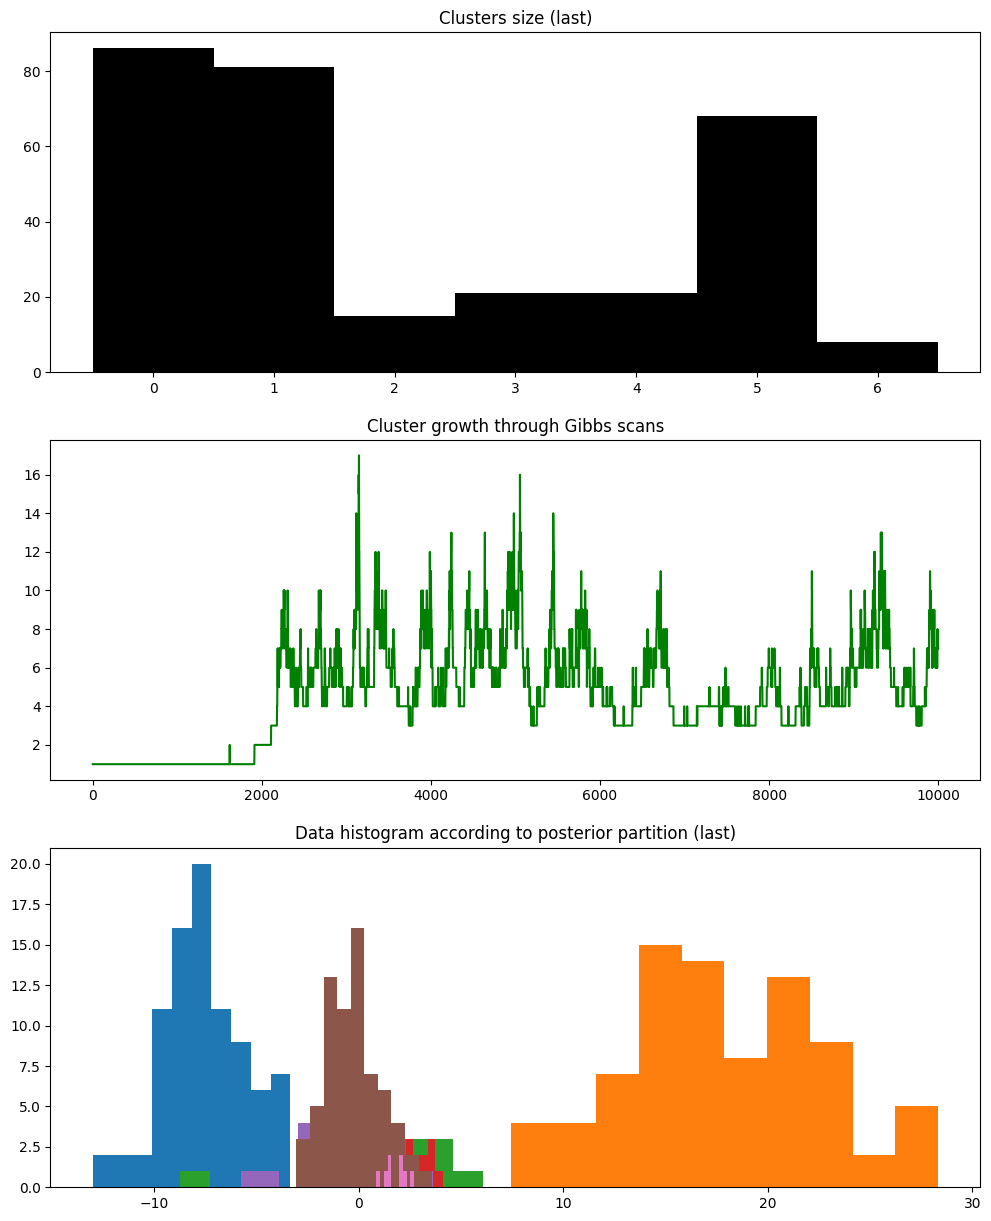

In [ ]:
#The first and last plot are generated according to the partition estimated by the last Gibbs iteration. Below you can find the ones generated with the optimal partition, which are more significative.
partition = partitions[-1]
fig = plt.figure(figsize = (12, 15))

#Plot 1
cluster_dim = [len(partition[i]) for i in range(len(partition))]
ax1 = fig.add_subplot(311)
plt.bar(x = range(len(partition)), height = cluster_dim, width = 1, color = 'k')
ax1.set_title('Clusters size (last)')

#Plot 2
ax2 = fig.add_subplot(312)
plt.plot(cluster_growth, 'g')
ax2.set_title('Cluster growth through Gibbs scans')

#Plot 3
ax3 = fig.add_subplot(313)
for i in range(len(partition)):
    plt.hist(sample[partition[i]])
ax3.set_title('Data histogram according to posterior partition (last)')

#plt.savefig('diagnostic.pdf')

### Density Estimation

Here we estimate the true data-generating distribution using MCMC runs of the algorithm above. We discard the first $5000$ iterations as burn-in phase.

In [ ]:
#Evaluating the predictive distribution on support
partitions = partitions[5000:] #discard first 5000 partitions (burn-in)
post_dens, pred_sample = posterior_predictive_pdf(support, gamma)

### Plotting

In [ ]:
#The rugs on the top of the density estimation plot are colored according to the partition estimated by the last Gibbs iteration. Below you can find the plot with rugs colored according to the optimal partition, which is more significative.
#Generating colors and weights for each cluster (for plotting purposes)
colors_post = np.array(['']*n, dtype = 'object')
importance = np.array([0]*n)
for i in range(len(partition)):
    importance[partition[i]] = len(partition[i])
    colors_post[partition[i]] = '#{:06x}'.format(random.randint(0, 0xFFFFFF)) #generate random hex color code

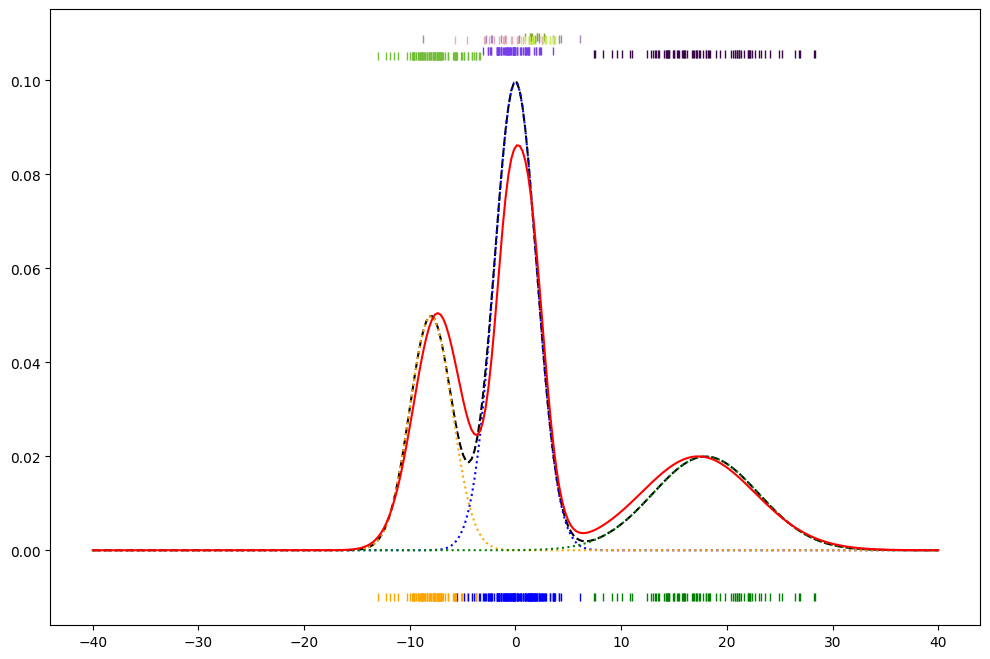

In [ ]:
#Plotting
maxx = max(max(mixture), max(post_dens))
fig = plt.figure(figsize = (12, 8))
ax = fig.add_subplot(111)
plt.plot(support, mixture, linestyle = 'dashed', color = 'k')
plt.plot(support, dens1*.5, linestyle = 'dotted', color = 'blue')
plt.plot(support, dens2*.25, linestyle = 'dotted', color = 'orange')
plt.plot(support, dens3*.25, linestyle = 'dotted', color = 'green')
plt.plot(support, post_dens, color = 'r')
for i in range(n):
    plt.plot(sample[i], -0.01, '|', color = colors[i])
    plt.plot(sample[i], maxx + 0.01 - (importance[i]*0.00005), '|', color = colors_post[i])
#ax.set_title('Mixture points allocations according to true density (bottom) and posterior (top, last)')
#plt.savefig('post_estim'+f'{n}'+'.pdf')

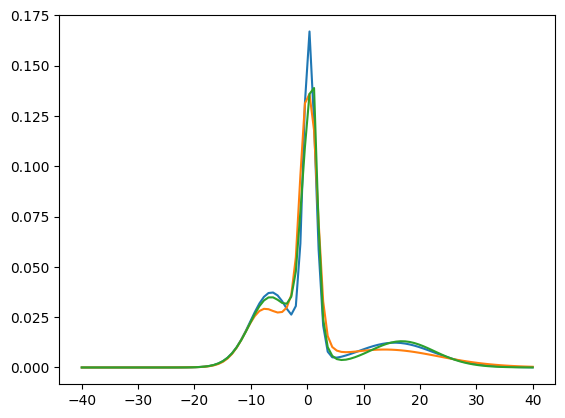

In [ ]:
#We pick at random some of the distributions averaged to obtain the above and we plot them.
for i in range(3):
    plt.plot(support, pred_sample[np.random.randint(0, 5000)])

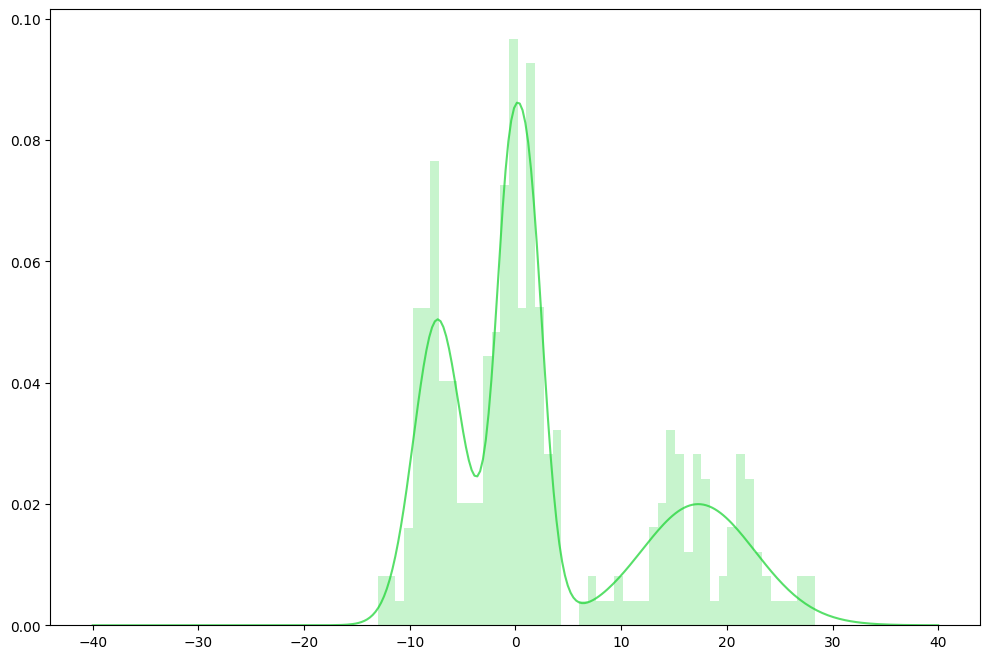

In [ ]:
#Data histogram vs. estimated density
fig, ax = plt.subplots(figsize = (12, 8))
ax.hist(sample, bins = 50, density = True, color = '#20D538', alpha = .25)
ax.plot(support, post_dens, color = '#20D538', alpha = .75)

### Salso

In [ ]:
#We convert the partitions object into a matrix with the same meaning
partitions_mat = np.zeros((T - 5000, n), dtype=np.int32)
for s in range(len(partitions)):
  numb_cl = len(partitions[s])
  for i in range(numb_cl):
    indexes = partitions[s][i]
    partitions_mat[s, indexes] = i+1

In [ ]:
#Activate conversion
numpy2ri.activate()
#Send to R
r_mat = robjects.r.matrix(partitions_mat, nrow=partitions_mat.shape[0], ncol=partitions_mat.shape[1])
print(partitions_mat)

[[6 1 6 ... 3 2 6]
 [3 1 4 ... 3 2 4]
 [7 1 3 ... 3 2 6]
 ...
 [6 1 5 ... 6 2 5]
 [6 1 6 ... 6 2 6]
 [4 1 6 ... 5 2 4]]


In [ ]:
#Run SALSO
results = salso.salso(r_mat)
print('Cluster assignment:', list(results))
opt_part_r = np.array(list(results))

Cluster assignment: [1, 2, 1, 1, 1, 1, 1, 1, 1, 2, 1, 2, 1, 3, 1, 2, 1, 2, 1, 1, 3, 3, 2, 2, 3, 3, 1, 1, 1, 3, 1, 1, 3, 2, 2, 1, 2, 3, 1, 3, 3, 2, 1, 3, 1, 1, 3, 1, 1, 1, 1, 2, 1, 1, 1, 1, 2, 1, 2, 2, 1, 1, 2, 1, 1, 2, 2, 2, 3, 2, 3, 1, 1, 3, 1, 1, 3, 1, 3, 2, 3, 2, 3, 1, 3, 3, 1, 3, 2, 2, 1, 3, 1, 2, 1, 1, 3, 2, 1, 2, 1, 2, 3, 1, 3, 2, 2, 3, 2, 3, 1, 1, 3, 2, 1, 3, 3, 3, 2, 1, 1, 1, 1, 1, 3, 2, 2, 3, 1, 1, 2, 3, 2, 1, 3, 1, 3, 2, 3, 2, 2, 1, 1, 1, 1, 1, 1, 2, 2, 1, 1, 3, 2, 1, 1, 2, 1, 2, 3, 3, 1, 1, 2, 3, 1, 1, 2, 1, 2, 2, 1, 3, 2, 1, 2, 2, 2, 1, 1, 1, 2, 1, 3, 1, 2, 3, 1, 2, 2, 3, 1, 1, 2, 3, 3, 3, 1, 1, 2, 3, 3, 2, 3, 2, 1, 1, 2, 2, 3, 3, 1, 3, 1, 1, 1, 2, 1, 3, 3, 1, 1, 1, 1, 3, 1, 3, 2, 3, 3, 3, 1, 2, 3, 1, 1, 2, 1, 2, 1, 3, 1, 3, 2, 1, 3, 2, 2, 1, 2, 3, 1, 3, 1, 3, 2, 3, 2, 2, 1, 2, 3, 3, 3, 2, 3, 1, 2, 2, 1, 1, 2, 1, 2, 1, 3, 2, 1, 1, 1, 3, 3, 3, 2, 1, 1, 3, 2, 3, 2, 2, 2, 3, 2, 1, 1, 1, 1, 1, 3, 1]


In [ ]:
#We convert the salso output into our partition format
opt_part = []
cl_number = np.unique(opt_part_r)
for i in range(len(cl_number)):
  opt_part.append(np.where(opt_part_r == cl_number[i])[0].tolist())

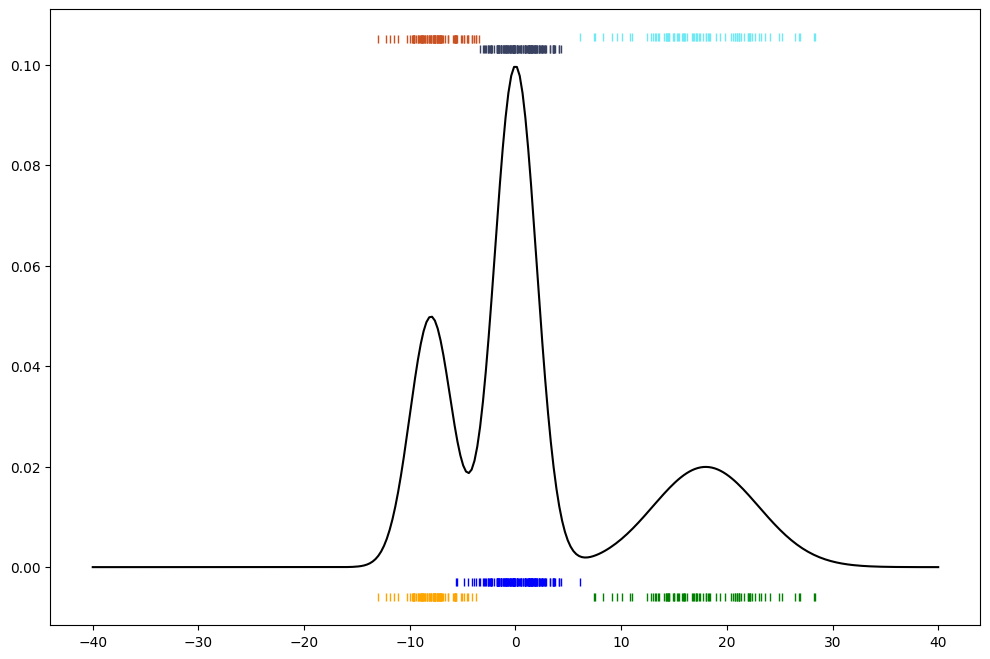

In [ ]:
#Similarly as before, we now plot the optimal partition from salso against the real sample from the mixture
#Determining colors and importance for optimal partition
col = ['#{:06x}'.format(random.randint(0, 0xFFFFFF)) for i in range(len(cl_number))]
opt_color = np.array(['']*n, dtype = 'object')
opt_importance = np.array([0]*n)
for i in range(len(cl_number)):
  opt_color[opt_part[i]] = col[i]
  opt_importance[opt_part[i]] = len(opt_part[i])

#Determining importance for original sample from the mixture
colors = np.array(colors) #otherwise we could have some problems with np.where
un_col = np.unique(colors)
importance = np.array([0]*n)
for i in range(len(un_col)):
  importance[np.where(colors == un_col[i])[0].tolist()] = counter[i]

#Plotting
fig, ax = plt.subplots(figsize = (12, 8))
ax.plot(support, mixture, color = 'black')
for i in range(n):
  ax.plot(sample[i], min(mixture) - 0.01 + (importance[i]*0.00005), '|', color = colors[i])
  ax.plot(sample[i], max(mixture) + 0.01 - (opt_importance[i]*0.00005), '|', color = opt_color[i])

In [ ]:
#Computing posterior similarity matrix
psm = salso.psm(r_mat)
#With this we reorder the rows and columns of the psm by the optimal cluster found by salso
order = np.argsort(opt_part_r)

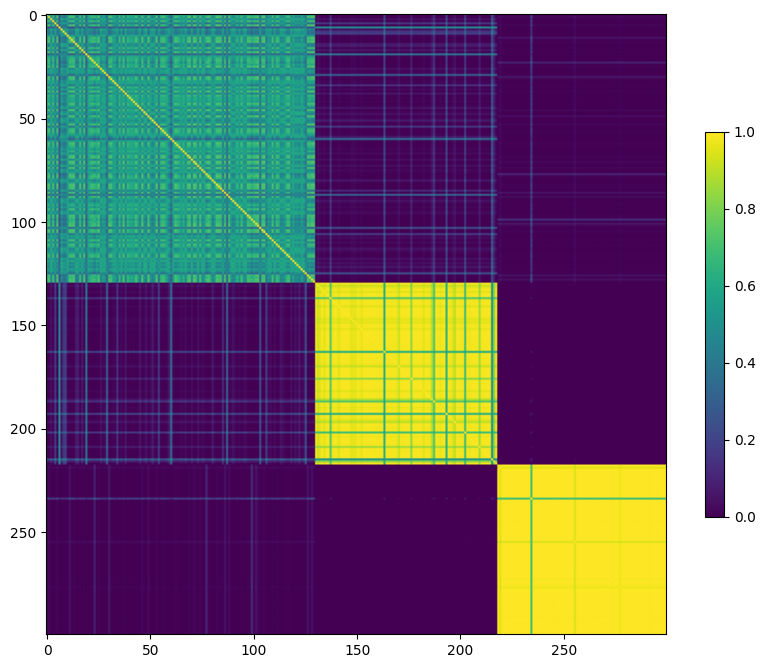

In [ ]:
#We now plot the reordered psm as an image using a color map.
fig = plt.figure(figsize = (10, 10))

ax1 = fig.add_subplot(111)
plot = ax1.imshow(psm[order][:, order], cmap = 'viridis') #we reorder rows and columns according to the 'best' partition from salso
plt.colorbar(plot, shrink = .5)
#ax1.set_axis_off()
plt.savefig('psm.pdf')

In [ ]:
#Get other metrics
binder_val   = salso.binder(results, r_mat)
vi_val       = salso.VI(results, r_mat)

print("Binder loss:", binder_val[0])
print("VI:", vi_val[0])

Binder loss: 0.15544444444444444
VI: 1.1551048072700898


### Density Estimation (Using as rug colors the optimal partition)

As above, we plot again the posterior density with rugs, but this time the rugs above are colored and moved according to the point estimate of the partitions, found using Salso package

In [ ]:
#Generating colors and weights for each cluster (for plotting purposes)
colors_post = np.array(['']*n, dtype = 'object')
importance = np.array([0]*n)
for i in range(len(opt_part)):
    importance[opt_part[i]] = len(opt_part[i])
    colors_post[opt_part[i]] = '#{:06x}'.format(random.randint(0, 0xFFFFFF)) #generate random hex color code

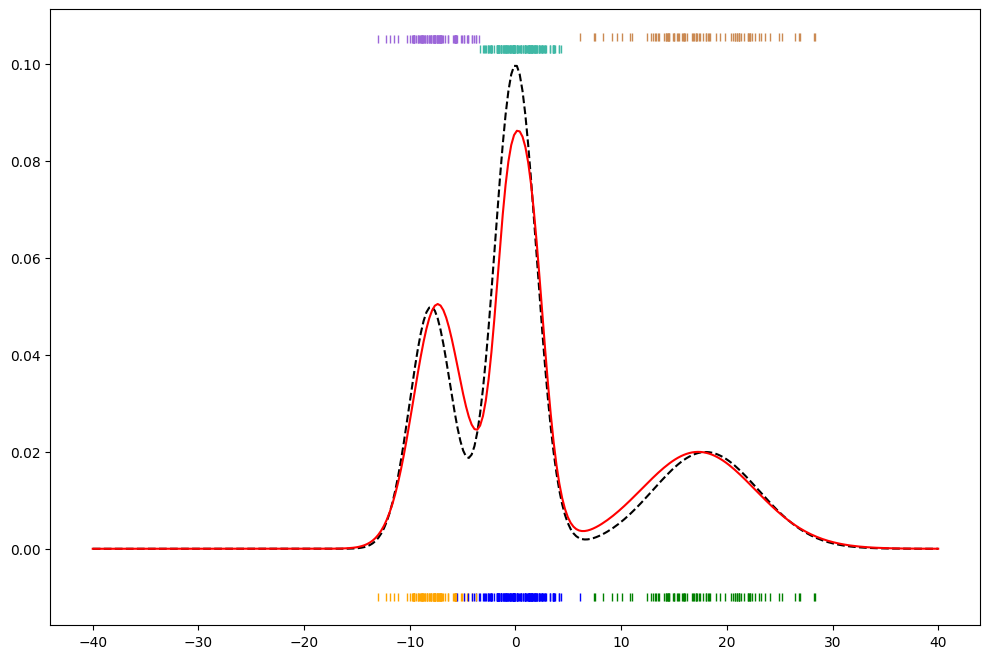

In [ ]:
#Plotting
maxx = max(max(mixture), max(post_dens))
fig = plt.figure(figsize = (12, 8))
ax = fig.add_subplot(111)
plt.plot(support, mixture, linestyle = 'dashed', color = 'k')
#plt.plot(support, dens1*.5, linestyle = 'dotted', color = 'blue')
#plt.plot(support, dens2*.25, linestyle = 'dotted', color = 'orange')
#plt.plot(support, dens3*.25, linestyle = 'dotted', color = 'green')
plt.plot(support, post_dens, color = 'r')
for i in range(n):
    plt.plot(sample[i], -0.01, '|', color = colors[i])
    plt.plot(sample[i], maxx + 0.01 - (importance[i]*0.00005), '|', color = colors_post[i])
#ax.set_title('Mixture points allocations according to true density (bottom) and posterior (top, last)')
plt.savefig('post_estim'+f'{n}'+'.pdf')

### Other plots using optimal partition

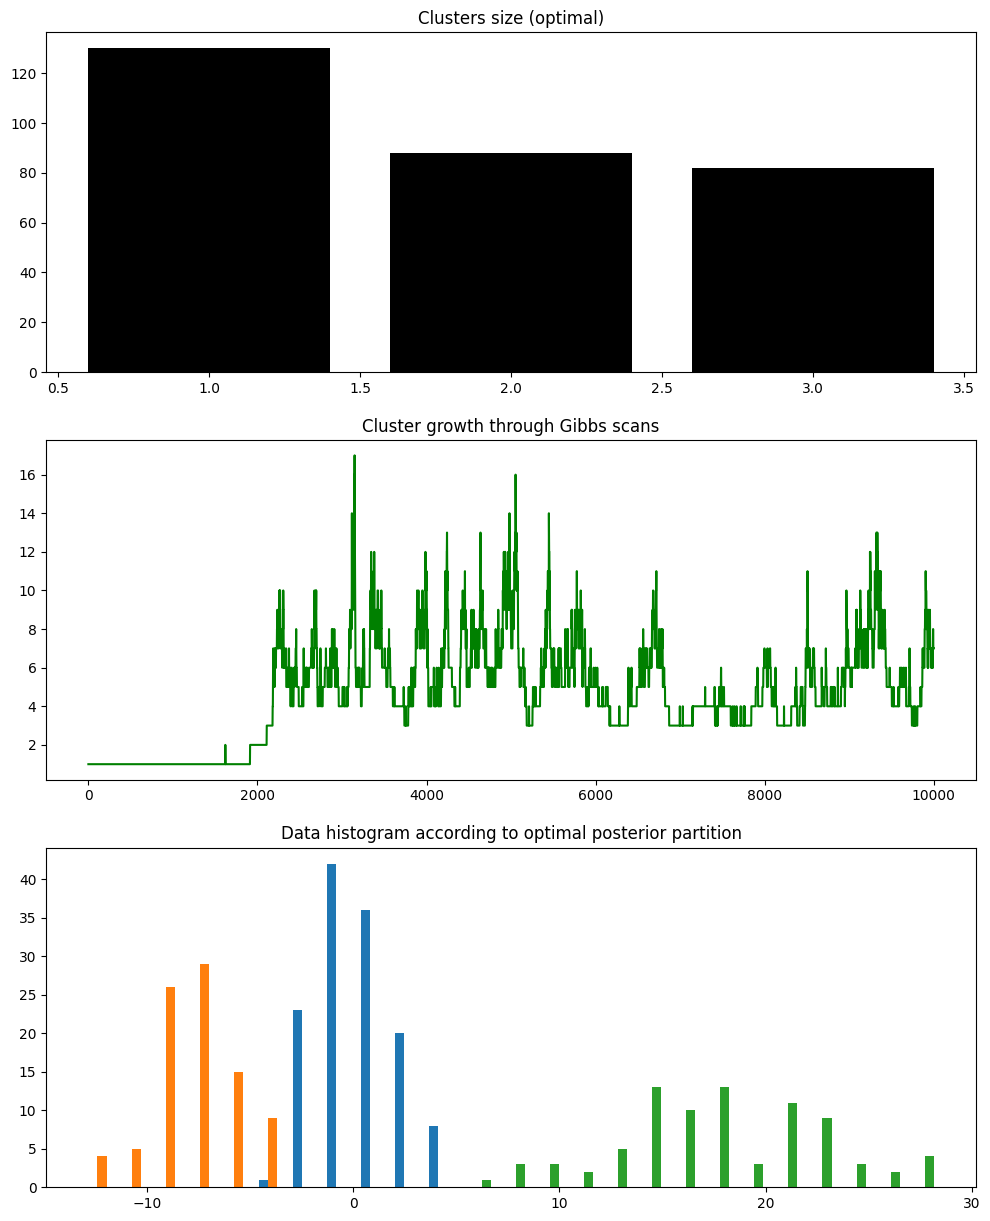

In [ ]:
#We now do the same plot as the first showed one but using the optimal partition, not the last iteration
fig, axes = plt.subplots(3, 1, figsize = (12, 15))
cl, counts = np.unique(opt_part_r, return_counts = True)
axes[0].bar(cl, counts, color = 'k')
axes[0].set_title('Clusters size (optimal)')

axes[1].plot(cluster_growth, 'g')
axes[1].set_title('Cluster growth through Gibbs scans')

masked_samp = []
for i in range(len(opt_part)):
  masked_samp.append(sample[opt_part[i]])
axes[2].hist(masked_samp, bins = 25)
axes[2].set_title('Data histogram according to optimal posterior partition')

plt.savefig('diagnostic.pdf')

# Real Data - Galaxy Dataset

Here we apply the model using real-world data. We will use the benchmark dataset, Galaxy

In [ ]:
os.chdir(r'/content/drive/MyDrive/Colab Notebooks/Thesis/Plots/mean variance/real data')

In [ ]:
#Import data
df = pd.read_csv(r'/content/drive/MyDrive/Colab Notebooks/Thesis/Datasets/galaxy.csv')
df.drop(columns = 'Nr')
df.shape

(3462, 65)

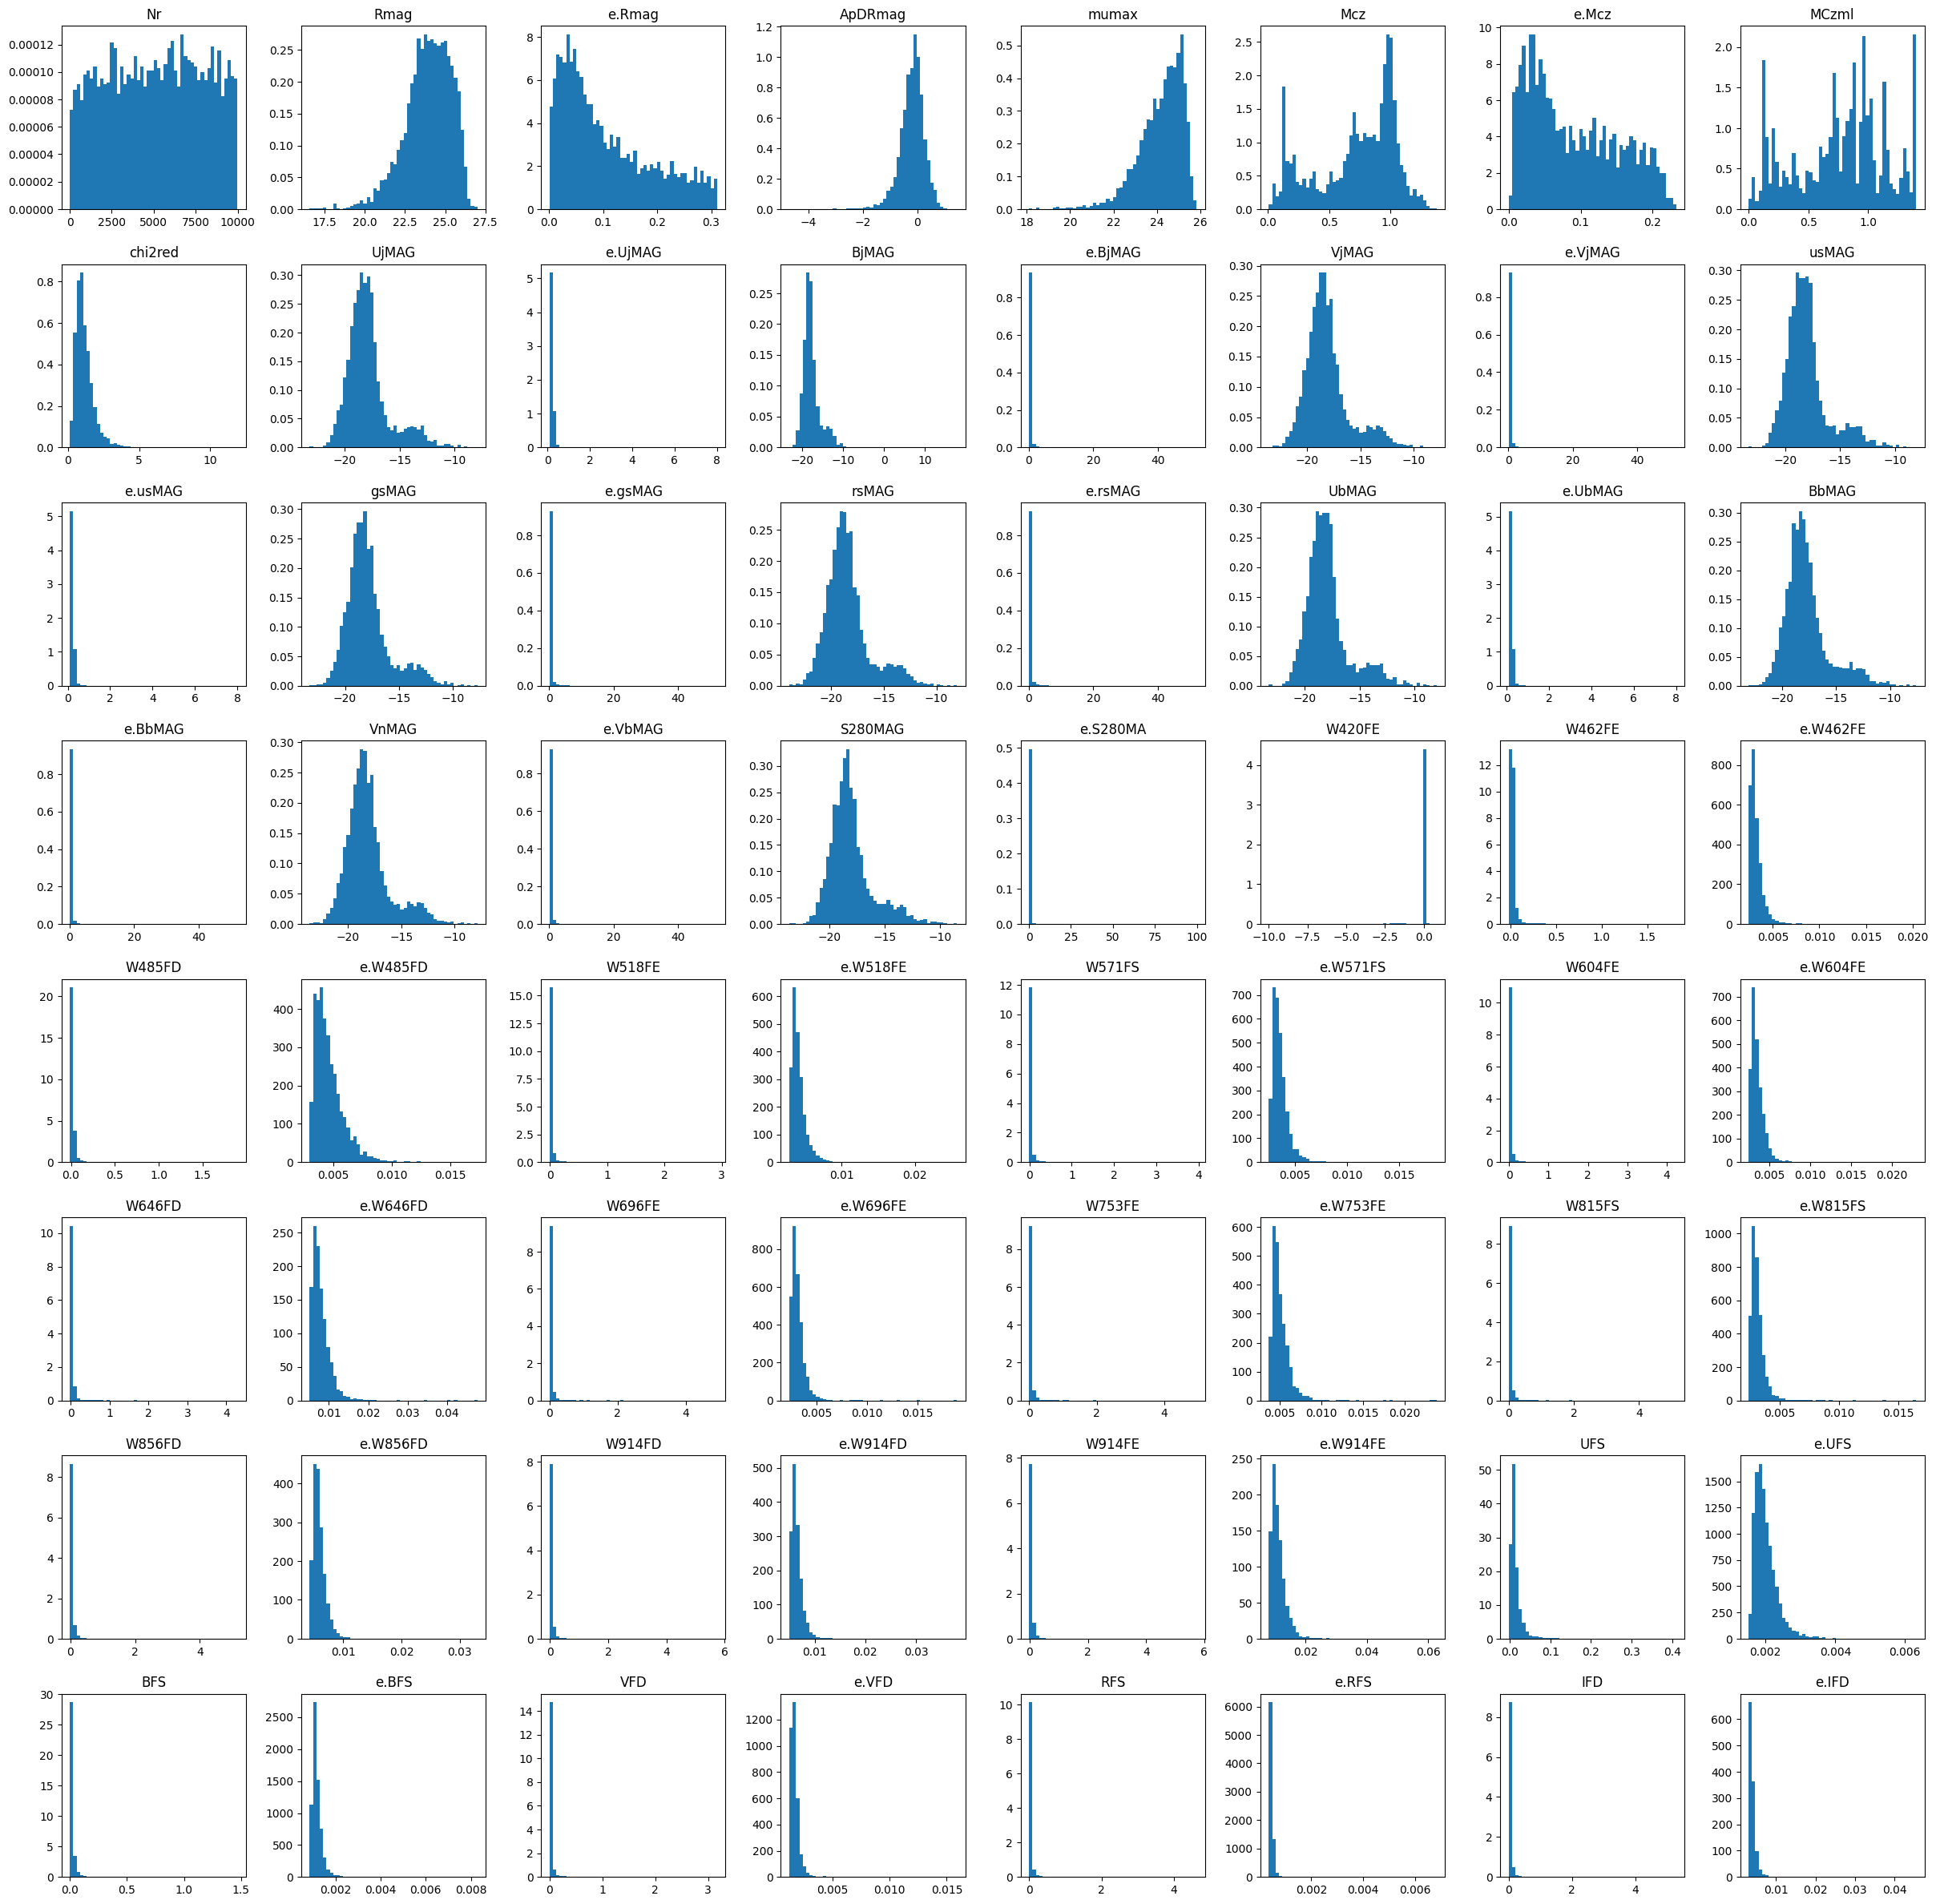

In [ ]:
fig, ax = plt.subplots(nrows = 8, ncols = 8, figsize = (30, 30))
df.hist(ax = ax, grid = False, density = True, bins = 50)
plt.savefig('df_col_hist.pdf')

In [ ]:
sample_whole = np.array(df['Mcz'])

In [ ]:
#Since the sample is too big, we random sample from it n observations to fit the model (otherwise it takes too much!)
n = 200
sample = np.random.choice(sample_whole, size = n)

(array([0.22710068, 1.70325511, 0.5677517 , 0.45420136, 0.45420136,
        0.22710068, 0.22710068, 0.11355034, 0.22710068, 0.        ,
        1.02195307, 0.34065102, 0.79485238, 0.5677517 , 1.24905375,
        0.79485238, 1.13550341, 1.02195307, 1.24905375, 0.90840273,
        2.72520818, 2.49810749, 1.36260409, 0.90840273, 0.68130204,
        0.        , 0.45420136, 0.68130204, 0.        , 0.11355034]),
 array([0.058     , 0.10203333, 0.14606667, 0.1901    , 0.23413333,
        0.27816667, 0.3222    , 0.36623333, 0.41026667, 0.4543    ,
        0.49833333, 0.54236667, 0.5864    , 0.63043333, 0.67446667,
        0.7185    , 0.76253333, 0.80656667, 0.8506    , 0.89463333,
        0.93866667, 0.9827    , 1.02673333, 1.07076667, 1.1148    ,
        1.15883333, 1.20286667, 1.2469    , 1.29093333, 1.33496667,
        1.379     ]),
 <BarContainer object of 30 artists>)

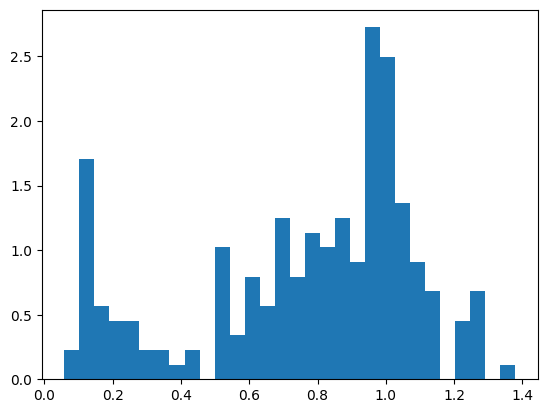

In [ ]:
#Just to visualize data distribution
plt.hist(sample, bins = 30, density = True)

In [ ]:
#We compute mean and variance of the sample to adjust hyperparameters easily
np.mean(sample), np.var(sample)

(np.float64(0.766135), np.float64(0.104826676775))

In [ ]:
#Params setting
T = 10000
gamma = 0.5
a = 15
b = .5
mu_0 = np.mean(sample)
beta = 1.5
partition = [[j for j in range(n)]]

In [ ]:
start = time.time()
probs = []
partitions = []
cluster_growth = [1]
lookup = {i : 0 for i in range(n)}
for t in tqdm(range(T)):
    for j in range(n):
        #Remove element j
        index = lookup.get(j)
        partition[index].remove(j)
        if not partition[index]:
            del partition[index]
            #Adjust lookup table by scaling the indexes
            for l in range(n):
                if lookup[l] > index:
                    lookup[l] = lookup[l] - 1
            #Should be faster but it's slower
            '''lookup = {key : value - 1 if lookup[key] > index else value for key, value in lookup.items()}'''
        #Compute probabilities of assignment for element j
        probs.append(cluster_prob(j, gamma))
        cluster_index = cluster_assign(probs[-1])
        if cluster_index == (len(probs[-1]) - 1): #i.e., if the index is referring to the probab. of getting a new cluster
            partition.append([j])
            #print('new cluster!')
        else:
            partition[cluster_index].append(j)
            #print('j-th element assigned to cluster', cluster_index)
        lookup[j] = cluster_index
    partitions.append(copy.deepcopy(partition))
    cluster_growth.append(len(partition))
print('Done!', round(time.time() - start, 3), 's')

100%|██████████| 10000/10000 [07:07<00:00, 23.40it/s]

Done! 427.695 s


### Diagnostic plots

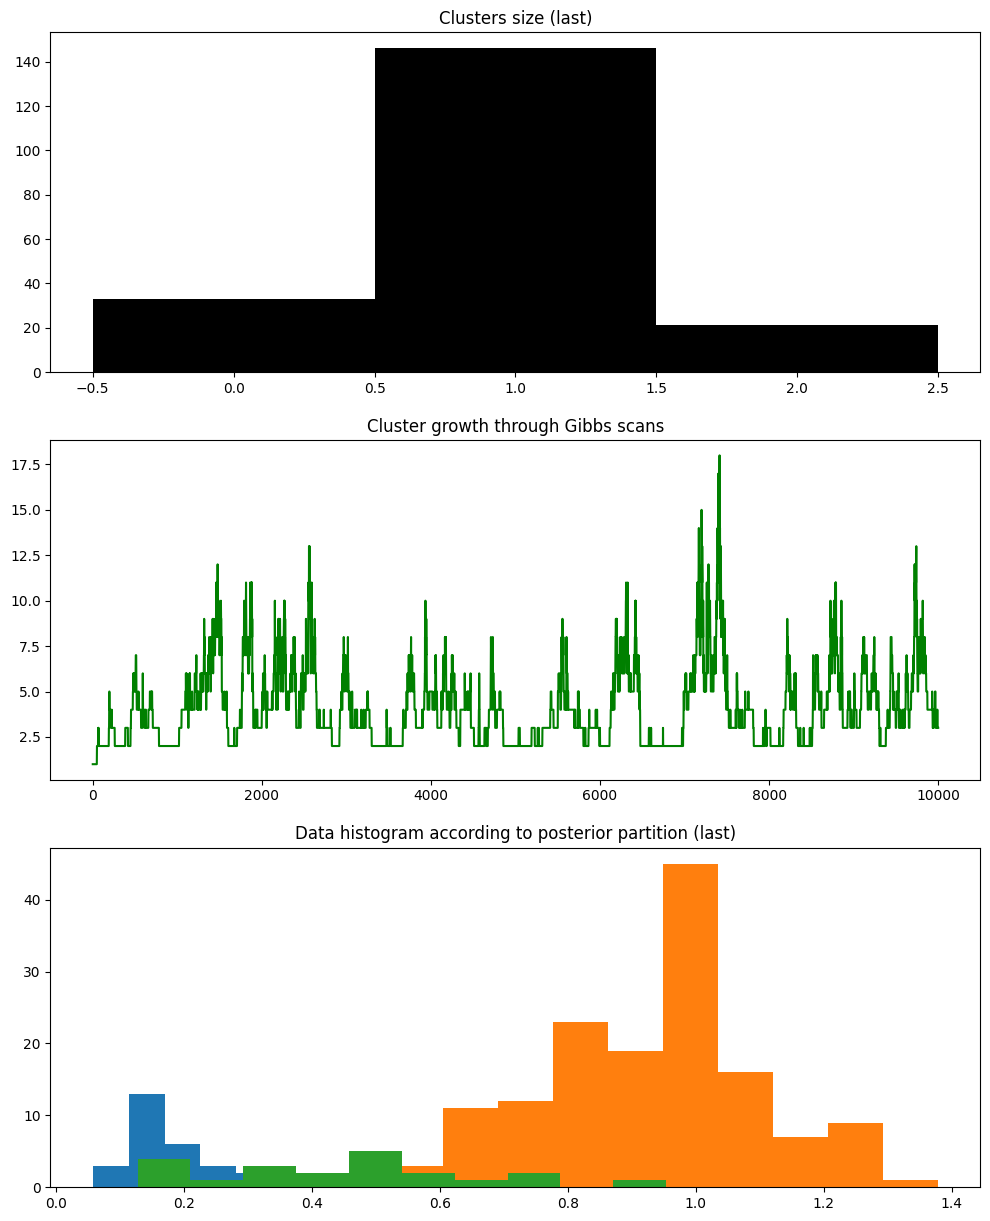

In [ ]:
#The first and last plot are generated according to the partition estimated by the last Gibbs iteration. Below you can find the ones generated with the optimal partition, which are more significative.
partition = partitions[-1]
fig = plt.figure(figsize = (12, 15))

#Plot 1
cluster_dim = [len(partition[i]) for i in range(len(partition))]
ax1 = fig.add_subplot(311)
plt.bar(x = range(len(partition)), height = cluster_dim, width = 1, color = 'k')
ax1.set_title('Clusters size (last)')

#Plot 2
ax2 = fig.add_subplot(312)
plt.plot(cluster_growth, 'g')
ax2.set_title('Cluster growth through Gibbs scans')

#Plot 3
ax3 = fig.add_subplot(313)
for i in range(len(partition)):
    plt.hist(sample[partition[i]])
ax3.set_title('Data histogram according to posterior partition (last)')

### KDE vs. Bayesian density estimation

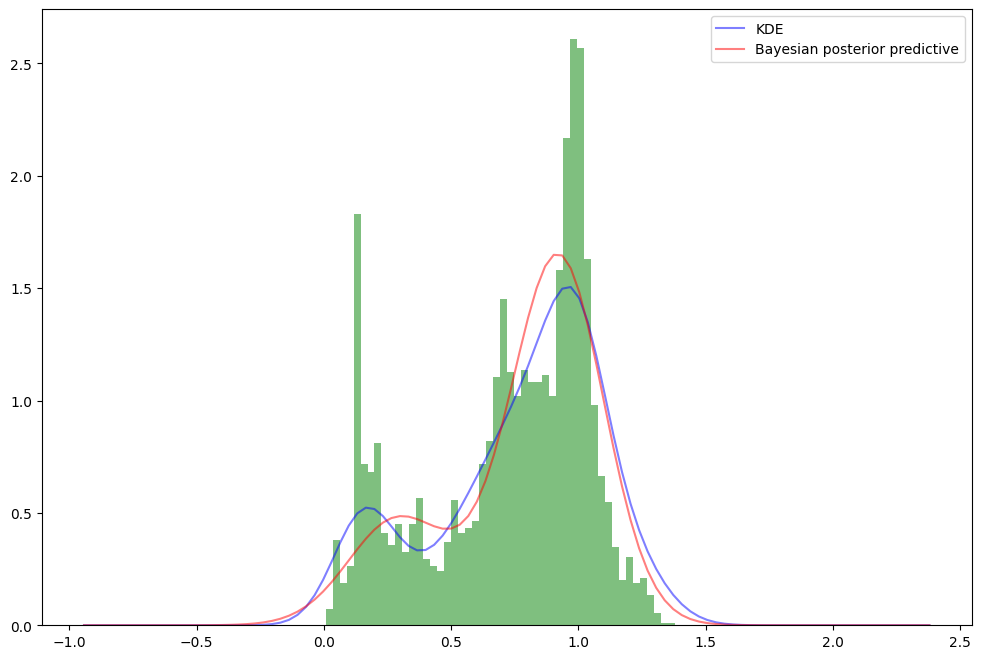

In [ ]:
#Building support
support = np.linspace(min(sample) - 1, max(sample) + 1, 100) #da aggiustare i limiti del linspace

#KDE
kde = ss.gaussian_kde(sample)
kde_eval = kde.pdf(support)

#Bayesian density estimation
partitions = partitions[5000:] #remove burn-in samples
post_dens = posterior_predictive_pdf(support, gamma)

#Plotting
fig = plt.figure(figsize = (12, 8))
ax = fig.add_subplot(111)
ax.hist(sample_whole, bins = 50, density = True, color = 'green', alpha= .5)
ax.plot(support, kde_eval, color = 'blue', alpha = .5, label = '1')
ax.plot(support, post_dens[0], color = 'red', alpha = .5, label = '2')
ax.legend(['KDE', 'Bayesian posterior predictive'])

plt.savefig('post_dens.pdf')

Cluster assignment: [1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 2, 2, 2, 1, 2, 1, 2, 2, 2, 2, 1, 2, 2, 1, 2, 1, 1, 2, 2, 2, 2, 2, 2, 1, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 1, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 1, 1, 2, 2, 1, 1, 2, 2, 2, 2, 2, 2, 2, 1, 1, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 1, 2, 2, 1, 2, 1, 1, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 1, 2, 1, 2, 2, 2, 2, 2, 2, 2, 1, 2, 1, 1, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 1, 2, 2, 1, 2, 2, 2, 2, 2, 2, 1, 1, 2, 2, 2, 1, 2, 2, 2, 1, 1, 2, 2, 2, 1, 2, 2, 2, 1, 2, 2, 2, 1, 2, 1]
Binder loss: 0.1128
VI: 0.5173049200940931


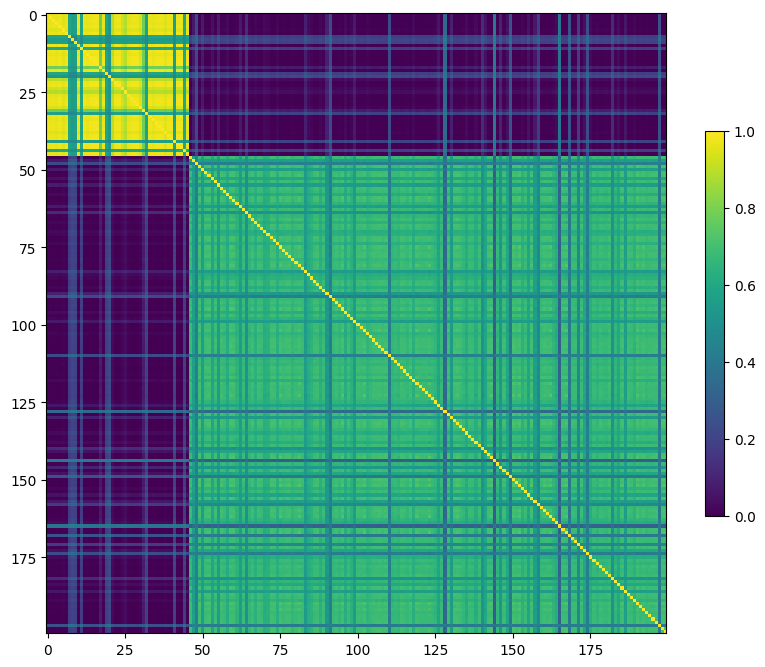

In [ ]:
#We convert the partitions object into a matrix with the same meaning
partitions_mat = np.zeros((T - 5000, n), dtype=np.int32)
for s in range(len(partitions)):
  numb_cl = len(partitions[s])
  for i in range(numb_cl):
    indexes = partitions[s][i]
    partitions_mat[s, indexes] = i+1

#Activate conversion
numpy2ri.activate()
#Send to R
r_mat = robjects.r.matrix(partitions_mat, nrow=partitions_mat.shape[0], ncol=partitions_mat.shape[1])

#Run SALSO
results = salso.salso(r_mat)
print('Cluster assignment:', list(results))
opt_part_r = np.array(list(results))

#Computing posterior similarity matrix
psm = salso.psm(r_mat)
#With this we reorder the rows and columns of the psm by the optimal cluster found by salso
order = np.argsort(opt_part_r)

#We now plot the reordered psm as an image using a color map.
fig = plt.figure(figsize = (10, 10))

ax1 = fig.add_subplot(111)
plot = ax1.imshow(psm[order][:, order], cmap = 'viridis') #we reorder rows and columns according to the 'best' partition from salso
plt.colorbar(plot, shrink = .5)
#ax1.set_axis_off()
plt.savefig('psm.pdf')

#Get other metrics
binder_val   = salso.binder(results, r_mat)
vi_val       = salso.VI(results, r_mat)

print("Binder loss:", binder_val[0])
print("VI:", vi_val[0])

### Other plots using optimal partition

In [ ]:
#We convert the salso output into our partition format
opt_part = []
cl_number = np.unique(opt_part_r)
for i in range(len(cl_number)):
  opt_part.append(np.where(opt_part_r == cl_number[i])[0].tolist())

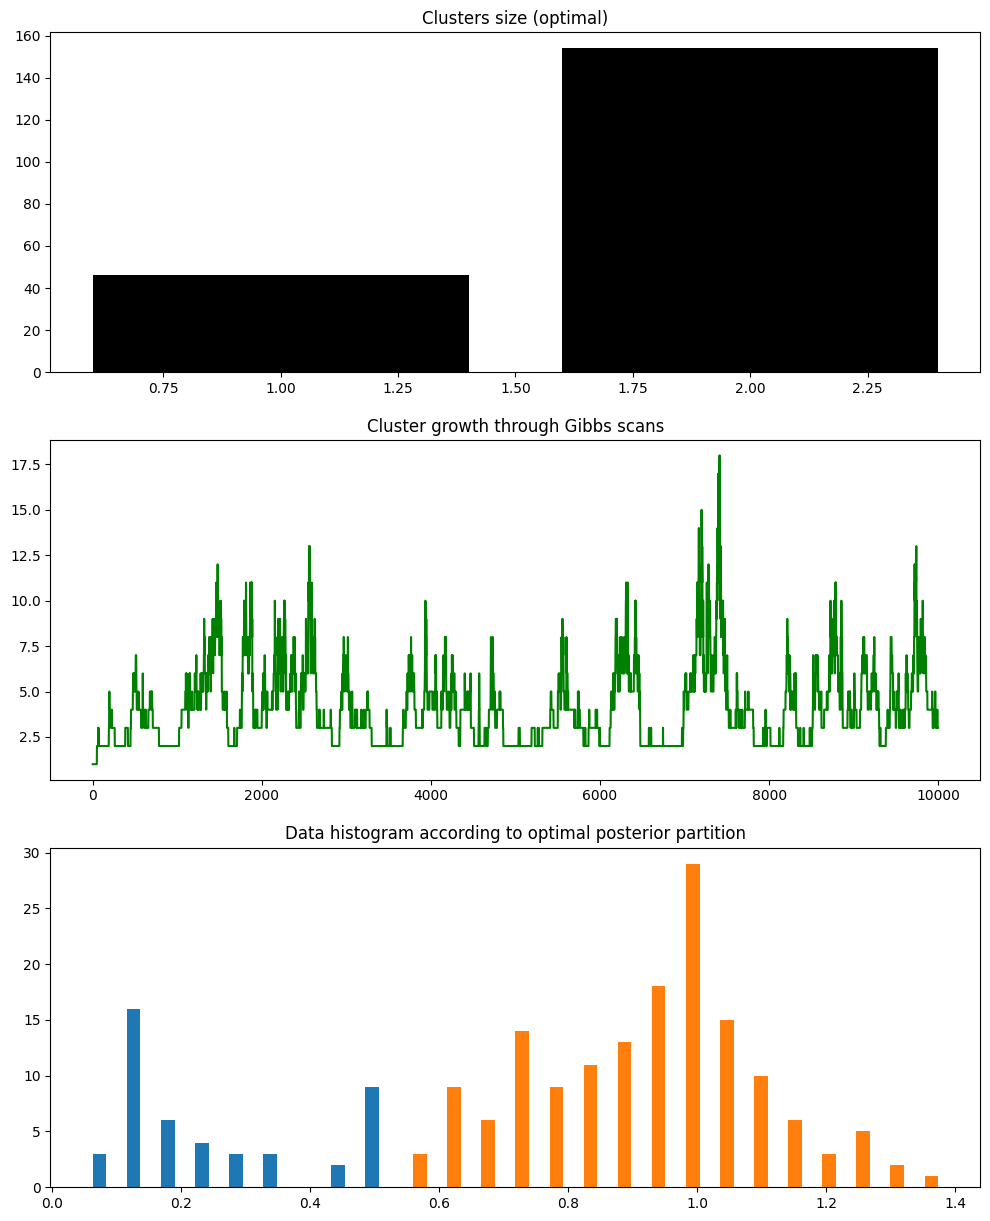

In [ ]:
#We now do the same plot as the first showed one but using the optimal partition, not the last iteration
fig, axes = plt.subplots(3, 1, figsize = (12, 15))
cl, counts = np.unique(opt_part_r, return_counts = True)
axes[0].bar(cl, counts, color = 'k')
axes[0].set_title('Clusters size (optimal)')

axes[1].plot(cluster_growth, 'g')
axes[1].set_title('Cluster growth through Gibbs scans')

masked_samp = []
for i in range(len(opt_part)):
  masked_samp.append(sample[opt_part[i]])
axes[2].hist(masked_samp, bins = 25)
axes[2].set_title('Data histogram according to optimal posterior partition')

plt.savefig('diagnostic.pdf')